# 2023-01-27からの派生課題

## Clusteringにおいて、**Controlのクラスタ数が１の状態で、Sampleが最大いくつに分かれるか**という設定のほうが良い可能性がある
### 利点
- 細かく分かれ過ぎるのを抑えることができる
- Controlが2つに分かれた時点で打ち切りにする、という明確な理由ができる
- Controlが2つに分かれた時点で打ち切りにできるので、計算量が減る

In [ ]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if os.getcwd() != "/mnt/d/Research/DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)
    print(os.getcwd())

['/mnt/d/Research/DAJIN2/misc/scripts', '/home/kuno/miniconda/lib/python310.zip', '/home/kuno/miniconda/lib/python3.10', '/home/kuno/miniconda/lib/python3.10/lib-dynload', '', '/home/kuno/miniconda/lib/python3.10/site-packages', '/mnt/d/Research/DAJIN2']
/mnt/d/Research/DAJIN2


In [2]:
# 必要なものを用意する
from importlib import reload
import re
from collections import Counter, defaultdict
from copy import deepcopy
from difflib import get_close_matches
from itertools import groupby, permutations
from pathlib import Path

import midsv
from scipy import stats
from scipy.spatial.distance import cosine

from src.DAJIN2.core import classification, clustering, consensus, preprocess, report
from src.DAJIN2.core.clustering import clustering
from src.DAJIN2.core.preprocess import mappy_align

# * flox insertion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "examples/flox-cables2/AyabeTask1/barcode31.fq.gz",
    "examples/flox-cables2/AyabeTask1/barcode42.fq.gz",
    "examples/flox-cables2/AyabeTask1/design_cables2.fa",
    "test-ayabe-task1",
    "mm10",
    True,
    14,
)

TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)


In [15]:
both_flox = "f855fb9b57ee"
left_loxp = "7089ae32a686"

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

for classif in classif_sample:
    classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)

for c in classif_sample:
    if both_flox in c["QNAME"]:
        print(f"both_flox: ALLELE = {c['ALLELE']}, SV = {c['SV']}")

for c in classif_sample:
    if left_loxp in c["QNAME"]:
        print(f"left_loxp: ALLELE = {c['ALLELE']}, SV = {c['SV']}")



both_flox: ALLELE = flox, SV = False
left_loxp: ALLELE = flox, SV = False


In [4]:
from src.DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci
from src.DAJIN2.core.clustering.preprocess import replace_both_ends_n
from src.DAJIN2.core.clustering.make_score import make_score
from src.DAJIN2.core.clustering.annotate_score import annotate_score
from src.DAJIN2.core.clustering.return_labels import return_labels


In [5]:
paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
cssplits_control_by_alleles = defaultdict(list)
for path_midsv in paths_midsv:
    midsv_control = midsv.read_jsonl(path_midsv)
    cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    allele = path_midsv.stem.split("_")[-1]
    cssplits_control_by_alleles[allele] = cssplits

knockin_alleles = extract_knockin_loci(TEMPDIR)

allele = "flox"
sv = False



In [6]:
knockin_loci = knockin_alleles[allele]
cssplits_control = cssplits_control_by_alleles[allele]
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele and cs["SV"] == sv]
cssplits_control = replace_both_ends_n(cssplits_control)
cssplits_sample = replace_both_ends_n(cssplits_sample)
"""
mutation_scoreの計算にknockin配列領域の情報を利用する
"""
mutation_score = make_score(cssplits_control, cssplits_sample, knockin_loci)
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)


In [7]:
labels = return_labels(scores_sample, scores_control)
Counter(labels)


Counter({1: 494, 2: 39})

# `return_labels`モジュールの変更
- **Controlのクラスタ数が１の状態で、Sampleが最大いくつに分かれるか**という設定にする

In [11]:
from __future__ import annotations
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from collections import Counter

from src.DAJIN2.core.clustering.merge_clusters import merge_clusters
from src.DAJIN2.core.clustering.reorder_labels import reorder_labels

###############################################################################
# Dimension reduction
###############################################################################


def reduce_dimension(scores_sample: list[list], scores_control_subset: list[list]) -> np.array:
    scores = scores_sample + scores_control_subset
    n_components = min(20, len(scores[0]))
    # TODO コメントアウトを消す
    # scaler = StandardScaler()
    # scores = scaler.fit_transform(scores)
    pca = PCA(n_components=n_components).fit(scores)
    # variance = pca.explained_variance_
    return pca.transform(scores)  # * variance


def optimize_labels(X: np.array, scores_sample: list[list], scores_control_subset: list[list]) -> list[int]:
    scores = scores_sample + scores_control_subset
    n_components = min(20, len(scores))
    for i in range(1, n_components):
        np.random.seed(seed=1)
        labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
        labels = labels.tolist()
        labels_sample = labels[: len(scores_sample)]
        labels_control = labels[len(scores_sample) :]
        labels_merged = merge_clusters(labels_control, labels_sample)
        labels_reorder = reorder_labels(labels_merged)
        if len(Counter(labels_control)) > 1:
            break
    return labels_reorder


###############################################################################
# main
###############################################################################


def return_labels(scores_sample: list[list], scores_control: list[list]) -> list[int]:
    np.random.seed(seed=1)
    X_control = reduce_dimension([], scores_control)
    labels = GaussianMixture(n_components=2, random_state=1).fit_predict(X_control)
    label_most = Counter(labels).most_common()[0][0]
    scores_control_subset = [s for l, s in zip(labels, scores_control) if l == label_most][:1000]
    X = reduce_dimension(scores_sample, scores_control_subset)
    labels = optimize_labels(X, scores_sample, scores_control_subset)
    return labels


In [12]:
np.random.seed(seed=1)
X_control = reduce_dimension([], scores_control)
labels = GaussianMixture(n_components=2, random_state=1).fit_predict(X_control)
label_most = Counter(labels).most_common()[0][0]
scores_control_subset = [s for l, s in zip(labels, scores_control) if l == label_most][:1000]
X = reduce_dimension(scores_sample, scores_control_subset)
labels = optimize_labels(X, scores_sample, scores_control_subset)


In [13]:
Counter(labels)

Counter({1: 494, 2: 39})

In [ ]:
samp = []
for i, cs in enumerate(classif_sample):
    if cs["ALLELE"] == allele and cs["SV"] == sv:
        samp.append(cs)

for i, cs in enumerate(samp):
    if left_loxp in cs["QNAME"]:
        print(i, "left")  # 212
    if both_flox in cs["QNAME"]:
        print(i, "both")  # 464


212 left
464 both


floxとleft_loxpが分かれているかを確認

In [20]:
print(labels[464])
print(labels[212])

1
2


# 結果
- ayabe-task1ではうまくクラスタリングされた

## 課題
- 短いリードをクラスタに入れたくない
- left_loxpは検出できたが、right_loxpはいまいちの様子
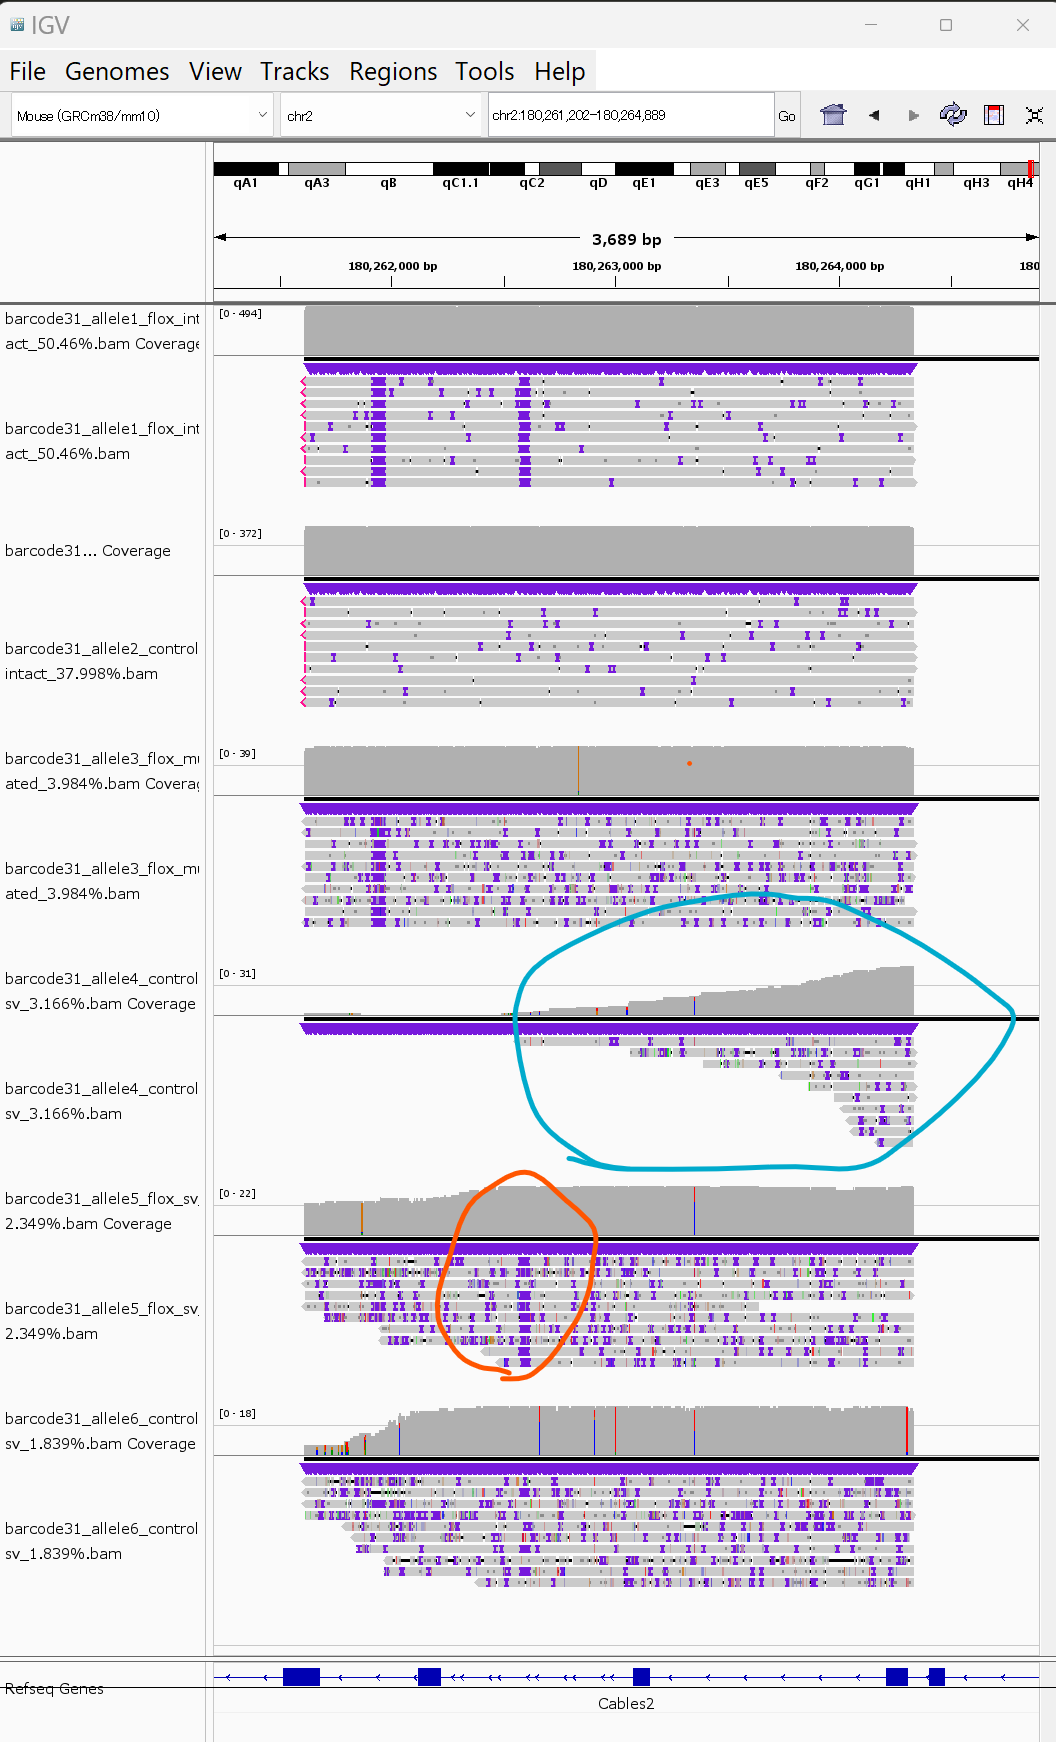

## 次回の挑戦
+ [ ] 点変異、欠失のデザインで動くかを確認する
+ [ ] right_loxpがいまいちな理由を考察する
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか